In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','text'])

## Feature Engineering

In [3]:
data['text_length'] = data['text'].apply(lambda x:len(x))

#### Clean The sms text

In [4]:
import re

In [5]:
def clean_text(x):
    letter_only = re.sub("[^a-zA-Z]", " ", x)
    return ' '.join(letter_only.split()).lower()

In [6]:
data['clean_text'] = data['text'].apply(clean_text)

In [7]:
data['clean_text_length'] = data['clean_text'].apply(lambda x:len(x))

#### Find Meaningfull word on every document

In [8]:
# CORPUS
# DOKUMEN
# Semakin Banyak kata tersebut muncul di dokument, semakin penting kata tersebut
# Semakin Banyak kata tersebut muncul di corpus, semakin tidak penting suatu kata
# TF = Term Frequency
# IDF = Inverse Document Frequency

In [9]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [10]:
count_vectorizer_transformer = CountVectorizer().fit(data['clean_text'])
count_vectorizer_res = count_vectorizer_transformer.transform(data['clean_text'])
tf_idf_transformer = TfidfTransformer().fit(count_vectorizer_res)
tf_idf_res = tf_idf_transformer.transform(count_vectorizer_res)
df_tf_idf = pd.DataFrame(tf_idf_res.todense() ,columns=count_vectorizer_transformer.get_feature_names())
meaningfull_words = []
for item in range(len(data)):
    words = list(df_tf_idf.iloc[item].sort_values(ascending=False).head(3).index)
    meaningfull_words.append(words)

data['meaningful words'] = meaningfull_words

In [11]:
data.head()

,label,text,text_length,clean_text,clean_text_length,meaningful words
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,102,"[jurong, amore, buffet]"
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23,"[oni, joking, wif]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final ...,126,"[fa, entry, tkts]"
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,43,"[say, hor, early]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...,60,"[he, lives, nah]"


## EDA

In [36]:
from nltk.corpus import stopwords

In [18]:
from collections import Counter

In [ ]:
import nltk
nltk.download('stopwords')

In [48]:
def show_most_words_appear(data):
    all_words =' '.join(list(data))
    list_all_words = all_words.split()
    word_count = Counter(list_all_words)
    word_count_series = pd.Series(word_count)
    word_wo_stopwords = []
    for item in word_count_series.index:
        if (item not in stopwords.words('english')):
            word_wo_stopwords.append(item)
    word_count_series = word_count_series.loc[word_wo_stopwords]
    most_words_appear = word_count_series.sort_values(ascending=False).head(20)
    plt.figure(figsize=(15,5))
    sns.barplot(most_words_appear.index, most_words_appear.values)

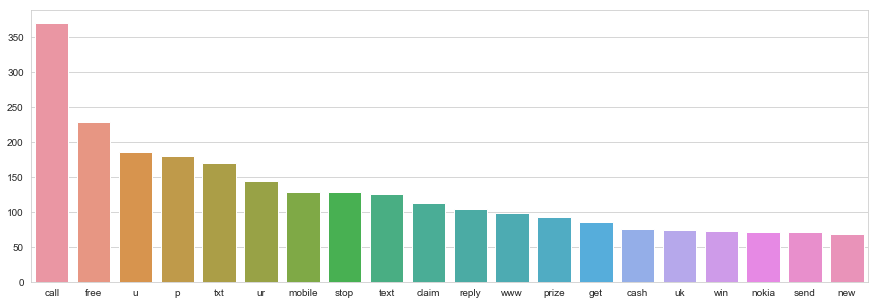

In [49]:
show_most_words_appear(data[data['label'] == 'spam']['clean_text'])

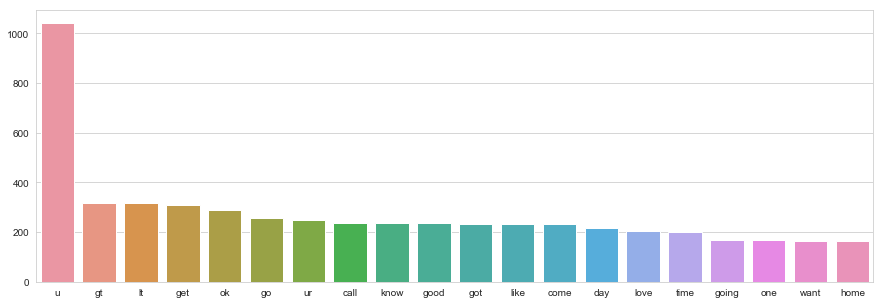

In [50]:
show_most_words_appear(data[data['label'] == 'ham']['clean_text'])

In [59]:
new_meaningfull = [' '.join(item) for item in data['meaningful words']]

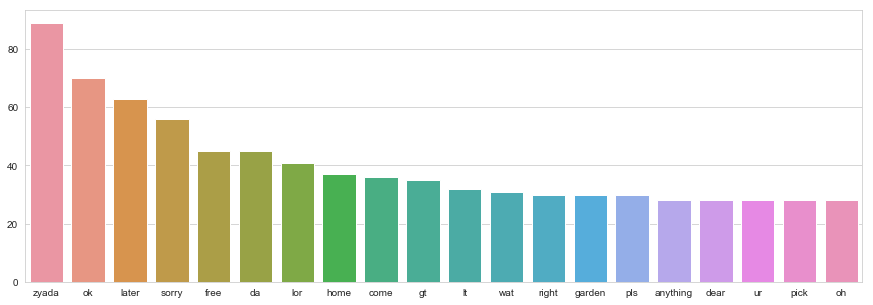

In [62]:
show_most_words_appear(pd.Series(new_meaningfull))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


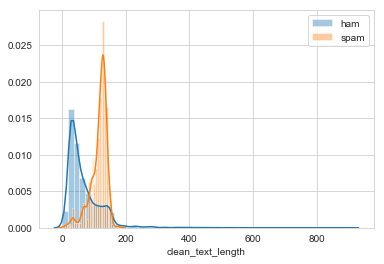

In [66]:
sns.distplot(data[data['label'] == 'ham']['clean_text_length'],label='ham')
sns.distplot(data[data['label'] == 'spam']['clean_text_length'],label='spam')
plt.legend()

## Modelling

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [72]:
# SPARSE METRIX Dari TFIDF

In [79]:
X_train,X_test,y_train,y_test = train_test_split(tf_idf_res , data['label'], random_state=101)

In [80]:
model_1 = MultinomialNB().fit(X_train,y_train)
prediction = model_1.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1227
        spam       1.00      0.64      0.78       166

   micro avg       0.96      0.96      0.96      1393
   macro avg       0.98      0.82      0.88      1393
weighted avg       0.96      0.96      0.95      1393



In [87]:
mes = 'you win our montly reward, pleas reply to this number to claim the reward'
cv = count_vectorizer_transformer.transform([mes])
tf = tf_idf_transformer.transform(cv)
model_1.predict(tf)

array(['spam'], dtype='<U4')